In [40]:
import autogen
import json
import os
from sentence_transformers import SentenceTransformer
import numpy as np
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import copy
import random

# Parameters (Needs to be configured to the specific task)

In [2]:
def read_task_output_file(file_name):
    """
    Read the task output logs
    
    Args:
    - file_name (str): The single log file that wants to get evaluated.
    """
    f = open( file_name,"r").readlines()
    output_dictionary = ""
    for line in f:
        if "is_correct" not in line and "correct_ans" not in line and  "check_result"  not in line:
            output_dictionary += line
        elif "is_correct" in line:
            correctness = line.replace(",","").split(":")[-1].rstrip().strip()
    return [output_dictionary,correctness]

In [3]:
# prompt related
response_successful = read_task_output_file("../test/test_files/agenteval-in-out/samples/sample_math_response_successful.txt")[0]
response_failed = read_task_output_file("../test/test_files/agenteval-in-out/samples/sample_math_response_failed.txt")[0]

task = {"name": "Math problem solving", 
        "description": "Given any question, the system needs to  solve the problem as consisely and  acccurately as possible",
        "examples": f"Task successful example: {response_successful}\nTask failed example: {response_failed}"}

sys_msg = f"""Task: {task["name"]}.
Task description: {task["description"]}
{task['examples']}
"""

In [57]:
# parameters, input path and output path
num_critic_seeds = 1
num_quantifier_seeds = 3
critic_agent_output_path_prefix = "../test/test_files/agenteval-in-out/task_based/Math_"
final_summarized_criteria_output_path = "final_filtered_criteria.json"
task_logs_input_path = "../test/test_files/agenteval-in-out/agentchat_results"
quantifier_agent_one_at_a_time_output_path_prefix = "evaluated_one_at_a_time-"
quantifier_agent_all_at_once_output_path_prefix = "evaluated_all_at_once_time-"
quantifier_stdev_plot_output_path = "mean_stdev_comparison.png"
adversarial_examples_output_path = "adversarial_examples.json"
adversarial_testing_evaluated_results_output_path = "adversarial_testing_evaluated_results.json"
quantifier_adversarial_testing_plot_output_path = "adversarial_quantifier_performance.png"

In [5]:
# load the original logs (directory might be structured differently)
original_test_cases = {}

for prefix in os.listdir(task_logs_input_path):
    for file_name in os.listdir(task_logs_input_path+"/"+prefix):
        gameid = prefix+"_"+file_name
        
        if file_name.split('.')[-1]=='json':
            test_case , actual_label = read_task_output_file(task_logs_input_path+"/"+prefix+'/'+file_name)
            original_test_cases[gameid] = [actual_label, test_case]

In [35]:
# Which part of the task output to drop might be different
def create_adversarial_samples(text):
    original_sample = json.loads(text)
    adversarial_sample = copy.deepcopy(original_sample)
    adversarial_sample['messages'] = []
    
    for m in original_sample['messages']: 
        if m['role'] == 'assistant':
            original_content = m['content']
            original_content_list = list(filter(lambda x: len(x) > 0, original_content.replace('. ', '\n').split('\n')))
            frac = 0.5 
            inds = set(random.sample(list(range(len(original_content_list))), int(frac*len(original_content_list))))
            new_content_list = [n for i,n in enumerate(original_content_list) if i not in inds]
            new_content = '\n'.join(new_content_list)
            adversarial_sample['messages'].append({'content': new_content, 'role': 'assistant'})
        else:
            adversarial_sample['messages'].append(m)
    
    return json.dumps(adversarial_sample, indent=2)

In [6]:
# LLM API
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
)

%env AUTOGEN_USE_DOCKER=0

env: AUTOGEN_USE_DOCKER=0


# Checkpoint 1: Run CriticAgent Multiple Times

In [7]:
for i in range(num_critic_seeds):
        
    critic = autogen.AssistantAgent(
        name = "critic",
        llm_config = {"config_list": config_list,"cache_seed":i},
        system_message = """You are a helpful assistant. You suggest criteria for evaluating different tasks. They should be dinstinguishable, quantifieable and not redundant.
        Convert the evaluation criteria into a dictionary where the keys are the criteria.
        The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
        Make sure the keys are criteria for assessing the given task.  "accepted_values" include the acceptable inputs for each key that are fine-grained and preferrably mlti-graded levels. "description" includes the criterion description.
        Return the dictionary."""
    )

    critic_user = autogen.UserProxyAgent(
        name = "critic_user",
        max_consecutive_auto_reply = 0,  # terminate without auto-reply
        human_input_mode = "NEVER",
    )

    gen_criteria = critic_user.initiate_chat(critic, message=sys_msg)
    criteria = critic_user.last_message()
    with open(critic_agent_output_path_prefix + str(i) + ".json", "w") as cr_file:
        crit_dict = json.loads(criteria["content"])
        json.dump(crit_dict,cr_file,indent=2)

critic_user (to critic):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_digit_facto

/opt/anaconda3/lib/python3.11/site-packages/autogen/agentchat/user_proxy_agent.py:83: UserWarning: Using None to signal a default code_execution_config is deprecated. Use {} to use default or False to disable code execution.
  super().__init__(


# Checkpoint 2: Generate Summarized Criteria

In [8]:
# load data
crit_dicts = []

for i in range(num_critic_seeds):
    with open(critic_agent_output_path_prefix + str(i) + ".json",'r') as fptr:
        criteria = json.load(fptr)
        crit_dicts.append(criteria)

In [9]:
criteria_summarizer_message_base = """You are a helpful assistant. You suggest criteria for evaluating different tasks. They should be dinstinguishable, quantifieable and not redundant.
A criteria dictionary is a dictionary where the keys are the criteria. 
The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
You will be given a list of criteria dictionaries that others have suggested. They will be of varying qualities, and some of them will be synonymous.
You should pick the best 25 distinct criteria for the task, and each criterion's corresponding best decription and range of accepted values.
Your output should be a criteria dictionary containing the 25 distinct criteria you have picked.
Make sure the keys are criteria for assessing the given task.  "accepted_values" include the acceptable inputs for each key that are fine-grained and preferrably mlti-graded levels. "description" includes the criterion description.
Return only the dictionary, and in json format."""

criteria_summarizer = autogen.AssistantAgent(
    name = "criteria_summarizer",
    llm_config = {"config_list": config_list},
    system_message = criteria_summarizer_message_base,
)

In [10]:
def get_summarized_criteria(crit_dicts):
    criteria_summarizer_user = autogen.UserProxyAgent(
        name = "criteria_summarizer_user",
        max_consecutive_auto_reply = 0,  # terminate without auto-reply
        human_input_mode = "NEVER",
    )    

    message = f"""Task: {task["name"]}.
Task description: {task["description"]}
Suggested criteria: {crit_dict}
"""

    criteria_summarizer_user.initiate_chat(criteria_summarizer, message=message)
    # return the last received from the criteria summarizer
    return criteria_summarizer_user.last_message()["content"]

In [11]:
summarized_criteria_list = []

for i in range(len(crit_dicts) // 25):
    summarized_criteria_list.append(get_summarized_criteria(crit_dicts[i*25 : (i+1)*25]))

final_summarized_criteria = get_summarized_criteria(summarized_criteria_list)

criteria_summarizer_user (to criteria_summarizer):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Suggested criteria: {'Accuracy': {'description': 'This criterion measures how accurate the solution provided by the system is. The solution is evaluated against the expected one for correctness.', 'accepted_values': ['100% - Completely correct', '75% - Mostly correct', '50% - Half correct', '25% - Few elements are correct', '0% - Incorrect']}, 'Completeness': {'description': 'This criterion assesses whether the solution provided by the system is complete or not. It checks if all necessary steps are included and the final solution is reached.', 'accepted_values': ['100% - Complete', '75% - Almost complete', '50% - Half finished', '25% - Few steps done', '0% - Not begun or irrelevant content']}, 'Clarity': {'description': 'The clarity criterion evaluates whether the steps in the solution are 

In [12]:
final_summarized_criteria = json.loads(final_summarized_criteria)

# convert to a list of words
conversion_dict_final = {}
for criteria in final_summarized_criteria:
    conversion_dict_final[' '.join(criteria.lower().split('_'))] = criteria

final_list_of_criteria = list(conversion_dict_final.keys())

In [13]:
# set up synonymous detection
def find_synonymous_in_list(word_list, threshold=0.75):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Load a pre-trained SentenceTransformer model
    embeddings = model.encode(word_list, convert_to_tensor=True)  # Compute embeddings for the word list

    processed_words = set()
    used_in_synonyms = set()
    synonymous_dict = {}

    for i, word in enumerate(word_list):
        if word not in processed_words and word not in used_in_synonyms:
            synonymous_list = []
            for j, other_word in enumerate(word_list):
                if i != j:
                    cosine_sim = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
                    if cosine_sim > threshold:
                        synonymous_list.append(other_word)
                        used_in_synonyms.add(other_word)
            if synonymous_list or word not in synonymous_dict:  # Check if synonymous_list is not empty or word is not already added
                synonymous_list = list(set(synonymous_list))  # Remove duplicates from the list
                synonymous_list.sort()  # Sort the list to make the output consistent
                synonymous_dict[word] = synonymous_list
            processed_words.add(word)
    
    return synonymous_dict

In [14]:
synonymous_dict = find_synonymous_in_list(final_list_of_criteria)
final_criteria = {}
for criteria in synonymous_dict:
    final_criteria[criteria] = final_summarized_criteria[conversion_dict_final[criteria]]

In [15]:
with open(final_summarized_criteria_output_path, "w") as outfile:
    json.dump(final_criteria, outfile, indent = 4)

# Checkpoint 3: Run QuantifierAgent (All Criteria At Once Version)

In [16]:
# load the criteria
with open(final_summarized_criteria_output_path) as crit_file:
    criteria = json.load(crit_file)

In [17]:
def run_quantifier_agent_all_criteria_at_once(num_seeds):
    quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
    The criterion is given in a dictionary format where each key is a dintinct criteria.
    The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
    You are going to quantify each of the crieria for a given task based on the task decription.
    Return a dictionary where the keys are the criteria and the values are the assessed performance based on accepted values for each criteria.
    Return only the dictionary as a json format string and nothing else."""

    for seed in range(num_seeds):
        outcome = {}
        quantifier = autogen.AssistantAgent(
            name = "quantifier",
            llm_config = {"config_list": config_list,"cache_seed":seed},
            system_message = quantifier_message_base)

        for gameid in original_test_cases:
            actual_label, test_case = original_test_cases[gameid]
    
            result = {"actual_success": actual_label, "estimated_performance": {}}

            quantifier_user = autogen.UserProxyAgent(
                name = "quantifier_user",
                max_consecutive_auto_reply = 0,  # terminate without auto-reply
                human_input_mode = "NEVER",
            )
            cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                            "Evaluation dictionary: " + str(criteria) + "\n" + \
                                            "actual test case to evaluate: " + test_case)
            quantified_result = quantifier_user.last_message()["content"]

            result["estimated_performance"] = json.loads(quantified_result)
                        
            outcome[gameid] = json.dumps(result)
                            
        # store the evaluated problems
        with open(quantifier_agent_all_at_once_output_path_prefix + str(seed) + ".json","w") as file:
            json.dump(outcome,file,indent=2) 

In [18]:
run_quantifier_agent_all_criteria_at_once(num_quantifier_seeds)

quantifier_user (to quantifier):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_dig

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


quantifier (to quantifier_user):

{"accuracy": "100% - Completely correct", "completeness": "100% - Complete", "clarity": "75% - Mostly clear", "efficiency": "75% - Mostly efficient"}

--------------------------------------------------------------------------------
quantifier_user (to quantifier):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through th

/opt/anaconda3/lib/python3.11/site-packages/autogen/agentchat/user_proxy_agent.py:83: UserWarning: Using None to signal a default code_execution_config is deprecated. Use {} to use default or False to disable code execution.
  super().__init__(


quantifier (to quantifier_user):

{"accuracy": "50% - Half correct", "completeness": "50% - Half finished", "clarity": "75% - Mostly clear", "efficiency": "75% - Mostly efficient"}

--------------------------------------------------------------------------------
quantifier_user (to quantifier):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the n

# Checkpoint 4: Run QuantifierAgent (One Criteria At a Time Version)

In [19]:
def run_quantifier_agent_one_criterion_a_time(num_seeds):
    quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
        You will be given a criterion a dictionary as follows {"description": criterion description , "accepted_values": possible accepted inputs for this key}.
        You are going to evaluate the test case against the given criterion for the given task.
        Return the assessed performance based on accepted values for each criteria, which must be one of the values provided in the accepted_values list.
        Return only the assessed performance and nothing else"""

    for seed in range(num_seeds):
        outcome = {}
        quantifier = autogen.AssistantAgent(
            name = "quantifier",
            llm_config = {"config_list": config_list,"cache_seed":seed},
            system_message = quantifier_message_base)

        for gameid in original_test_cases:
            actual_label, test_case = original_test_cases[gameid]
    
            result = {"actual_success": actual_label, "estimated_performance": {}}

            for criterion in criteria:
                quantifier_user = autogen.UserProxyAgent(
                    name = "quantifier_user",
                    max_consecutive_auto_reply = 0,  # terminate without auto-reply
                    human_input_mode = "NEVER",
                )
                cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                                "Evaluation criterion: " + criterion + "\n" + \
                                                "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                                "actual test case to evaluate: " + test_case)
                quantified_result = quantifier_user.last_message()["content"]

                result["estimated_performance"][criterion] = quantified_result
                        
            outcome[gameid] = json.dumps(result)
                            
        # store the evaluated problems
        with open(quantifier_agent_one_at_a_time_output_path_prefix + str(seed) + ".json","w") as file:
            json.dump(outcome,file,indent=2) 

In [20]:
run_quantifier_agent_one_criterion_a_time(num_quantifier_seeds)

quantifier_user (to quantifier):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successful example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_dig

# Checkpoint 5: Plot QuantifierAgent Standard Deviation

In [26]:
# convert accepted value to score
level2score = defaultdict(lambda: defaultdict(int))
for criterion in criteria:
     score = 0
     for v in criteria[criterion]["accepted_values"]:
        level2score[criterion][v] = score
        score += 1
print(level2score)

defaultdict(<function <lambda> at 0x1677fe700>, {'accuracy': defaultdict(<class 'int'>, {'100% - Completely correct': 0, '75% - Mostly correct': 1, '50% - Half correct': 2, '25% - Few elements are correct': 3, '0% - Incorrect': 4}), 'completeness': defaultdict(<class 'int'>, {'100% - Complete': 0, '75% - Almost complete': 1, '50% - Half finished': 2, '25% - Few steps done': 3, '0% - Not begun or irrelevant content': 4}), 'clarity': defaultdict(<class 'int'>, {'100% - Very clear': 0, '75% - Mostly clear': 1, '50% - Somewhat clear': 2, '25% - Not clear': 3, '0% - Confusing or irrelevant': 4}), 'efficiency': defaultdict(<class 'int'>, {'100% - Very efficient': 0, '75% - Mostly efficient': 1, '50% - Average efficiency': 2, '25% - Not efficient': 3, '0% - Inefficient or irrelevant': 4})})


In [21]:
def get_stdevs_from_quantified_output(num_seeds, path_prefix):
    results = defaultdict(lambda: defaultdict(list)) # result[criterion][game] gives a list of num_seeds scores for that game 
    key_errors = defaultdict(int)
    
    for seed in range(num_seeds):
        # Load outcome data for the current seed
        with open(path_prefix + str(seed) + ".json", 'r') as file:
            outcome = json.load(file)
    
            for game in outcome:
                gameid = game.strip(".json")
                quantified_result = json.loads(outcome[game])['estimated_performance']

                for criterion in quantified_result:
                    cleaned_level = quantified_result[criterion].strip("'")
                    results[criterion][gameid].append(level2score[criterion][cleaned_level])
        
    stdevs = defaultdict(lambda: defaultdict(float))
    
    for criterion in results:
        for game in results[criterion]:
            stdevs[criterion][game] = statistics.stdev(results[criterion][game])
        
    stdevs_list = {}
    for criterion in stdevs:
        stdevs_list[criterion] = []
        for game in stdevs[criterion]:
            stdevs_list[criterion].append(stdevs[criterion][game])

    mean_stdevs = {}
    for criterion in stdevs_list:
        mean_stdevs[criterion] = statistics.mean(stdevs_list[criterion])

    return (stdevs_list, mean_stdevs, key_errors, results)

In [27]:
exp1_stdevs_list, exp1_mean_stdevs, exp1_key_errors, exp1_results = get_stdevs_from_quantified_output(num_quantifier_seeds, quantifier_agent_all_at_once_output_path_prefix)
exp2_stdevs_list, exp2_mean_stdevs, exp2_key_errors, exp2_results = get_stdevs_from_quantified_output(num_quantifier_seeds, quantifier_agent_one_at_a_time_output_path_prefix)

In [28]:
def plot_quantifier_stdev():
    plt.figure(figsize=(12, 8))
    bar_width = 0.2
    index = np.arange(len(criteria))
    
    criteria_names = list(criteria.keys())
    
    exp1_data = []
    exp2_data = []
    for criterion in criteria_names:
        exp1_data.append(exp1_mean_stdevs[criterion])
        exp2_data.append(exp2_mean_stdevs[criterion])
    
    plt.bar(index , exp1_data, bar_width, label=f"all in one", color="blue", capsize=5)
    plt.bar(index + bar_width, exp2_data, bar_width, label=f"one criterion per prompt", color="orange", capsize=5)
    
    plt.xlabel("Criteria", fontsize=16)
    plt.ylabel("Mean Standard Deviation", fontsize=16)
    plt.xticks(index + bar_width / 2, criteria_names, rotation=90, fontsize=14)
    plt.legend(loc="upper center", fontsize=14, bbox_to_anchor=(0.5, 1), ncol=3)  # Adjust legend placement and ncol
    plt.tight_layout()  # Adjust subplot parameters to fit the labels
    plt.savefig(quantifier_stdev_plot_output_path)
    plt.show()

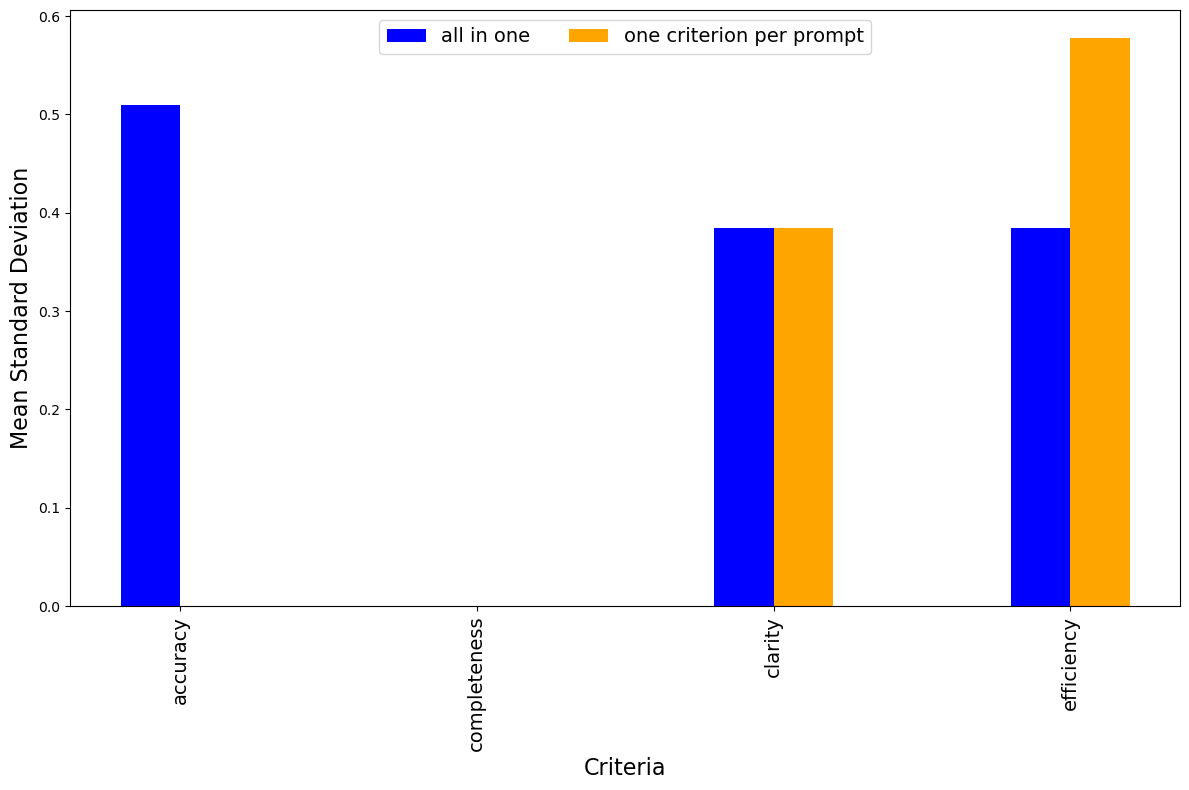

In [32]:
plot_quantifier_stdev()

# Checkpoint 6: Generate Adversarial Samples

In [45]:
adversarial_test_cases = {}
for gameid in original_test_cases:
    actual_label, test_case = original_test_cases[gameid]

    adversarial_test_case = create_adversarial_samples(test_case)
    adversarial_test_cases[gameid] = adversarial_test_case
    
with open(adversarial_examples_output_path,"w") as file:
    json.dump(adversarial_test_cases,file,indent=2) 

# Checkpoint 7: Run QuantifierAgent on Adversarial Samples

In [52]:
def run_quantifier_on_adversarial_samples():
    quantifier_message_base = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
        You will be given a criterion a dictionary as follows {"description": criterion description , "accepted_values": possible accepted inputs for this key}.
        You are going to evaluate the test case against the given criterion for the given task.
        Return the assessed performance based on accepted values for each criteria, which must be one of the values provided in the accepted_values list.
        Return only the assessed performance and nothing else"""

    quantifier = autogen.AssistantAgent(
        name = "quantifier",
        llm_config = {"config_list": config_list},
        system_message = quantifier_message_base)

    outcome = {}
    
    for gameid in original_test_cases:
        actual_label, test_case = original_test_cases[gameid]
        adversarial_test_case = adversarial_test_cases[gameid]

        result = {"actual_success": actual_label, "estimated_performance": {}}

        for criterion in criteria:
            quantifier_user = autogen.UserProxyAgent(
                name = "quantifier_user",
                max_consecutive_auto_reply = 0,  # terminate without auto-reply
                human_input_mode = "NEVER",
            )
            cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                            "Evaluation criterion: " + criterion + "\n" + \
                                            "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                            "actual test case to evaluate: " + test_case)
            quantified_result = quantifier_user.last_message()["content"]

            original_result = quantified_result

            quantifier_user = autogen.UserProxyAgent(
                name = "quantifier_user",
                max_consecutive_auto_reply = 0,  # terminate without auto-reply
                human_input_mode = "NEVER",
            )
            cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                            "Evaluation criterion: " + criterion + "\n" + \
                                            "Evaluation dictionary: " + str(criteria[criterion]) + "\n" + \
                                            "actual test case to evaluate: " + adversarial_test_case)
            quantified_result = quantifier_user.last_message()["content"]

            adversarial_result = quantified_result

            result['estimated_performance'][criterion] = [original_result, adversarial_result]        
                
        outcome[gameid] = json.dumps(result)
                        
    # store the evaluated problems
    with open(adversarial_testing_evaluated_results_output_path,"w") as file:
        json.dump(outcome,file,indent=2) 

In [53]:
run_quantifier_on_adversarial_samples()

{
  "problem": "A cook has 10 red peppers and 5 green peppers. If the cook selects 6 peppers at random, what is the probability that he selects at least 4 green peppers? Express your answer as a common fraction.",
  "level": "Level 5",
  "type": "Counting & Probability",
  "solution": "We can count the number of ways to choose a group of 4 green and 2 red peppers and the number of ways to choose 5 green and 1 red peppers. These are $\\binom{5}{4}\\binom{10}{2}=5\\cdot45=225$ and $\\binom{5}{5}\\binom{10}{1}=10$. The total number of ways the cook can choose peppers is $\\binom{15}{6}=5005$. Therefore, the probability that out of six randomly chosen peppers at least four will be green is $\\frac{235}{5005}=\\boxed{\\frac{47}{1001}}$.",
  "problem_id": "16",
  "response_with_ans": "My mistake, I can write the code for you. Execute the following Python code to calculate the probability:\n\n```python\nimport math\n\ndef combination(n, k):\n    return math.factorial(n) / (math.factorial(k) *

# Checkpoint 8: Plot QuantifierAgent Adversarial Testing Performance

In [54]:
# load data
with open(adversarial_testing_evaluated_results_output_path) as file:
    original_outcome = json.load(file)

original_adversarial_exp_scores = defaultdict(lambda: defaultdict(list))

for game in original_outcome:
    evaluated_results = json.loads(original_outcome[game])['estimated_performance']
    for criterion in evaluated_results:
        original_level, adversarial_level = evaluated_results[criterion]
        
        original_score = level2score[criterion][original_level.strip('"').strip("'")]
        adversarial_score = level2score[criterion][adversarial_level.strip('"').strip("'")]
        
        original_adversarial_exp_scores[criterion]['original'].append(original_score)
        original_adversarial_exp_scores[criterion]['adversarial'].append(adversarial_score)

original_averages = defaultdict(lambda: defaultdict(float))

for criterion in original_adversarial_exp_scores:
    original_averages[criterion]["original"] =  statistics.mean(original_adversarial_exp_scores[criterion]["original"])
    original_averages[criterion]["adversarial"] =  statistics.mean(original_adversarial_exp_scores[criterion]["adversarial"])

In [55]:
def plot_quantifier_adversarial_testing():
    plt.figure(figsize=(12, 8))
    bar_width = 0.2
    index = np.arange(len(criteria))
    
    criteria_names = list(criteria.keys())
    
    exp1_data = []
    exp2_data = []
    
    for criterion in criteria_names:
        exp1_data.append(original_averages[criterion]['original'])
        exp2_data.append(original_averages[criterion]['adversarial'])
    
    plt.bar(index , exp1_data, bar_width, label=f"original sample", color="darkblue", capsize=5)
    plt.bar(index + bar_width, exp2_data, bar_width, label=f"adversarial sample", color="lightblue", capsize=5)
    
    plt.xlabel("Criteria", fontsize=16)
    plt.ylabel("Average Quantified Score", fontsize=16)
    plt.xticks(index + bar_width / 2, criteria_names, rotation=90, fontsize=14)
    plt.legend(loc="upper center", fontsize=14, bbox_to_anchor=(0.5, 1), ncol=3)  # Adjust legend placement and ncol
    plt.tight_layout()  # Adjust subplot parameters to fit the labels
    plt.savefig(quantifier_adversarial_testing_plot_output_path)
    plt.show()

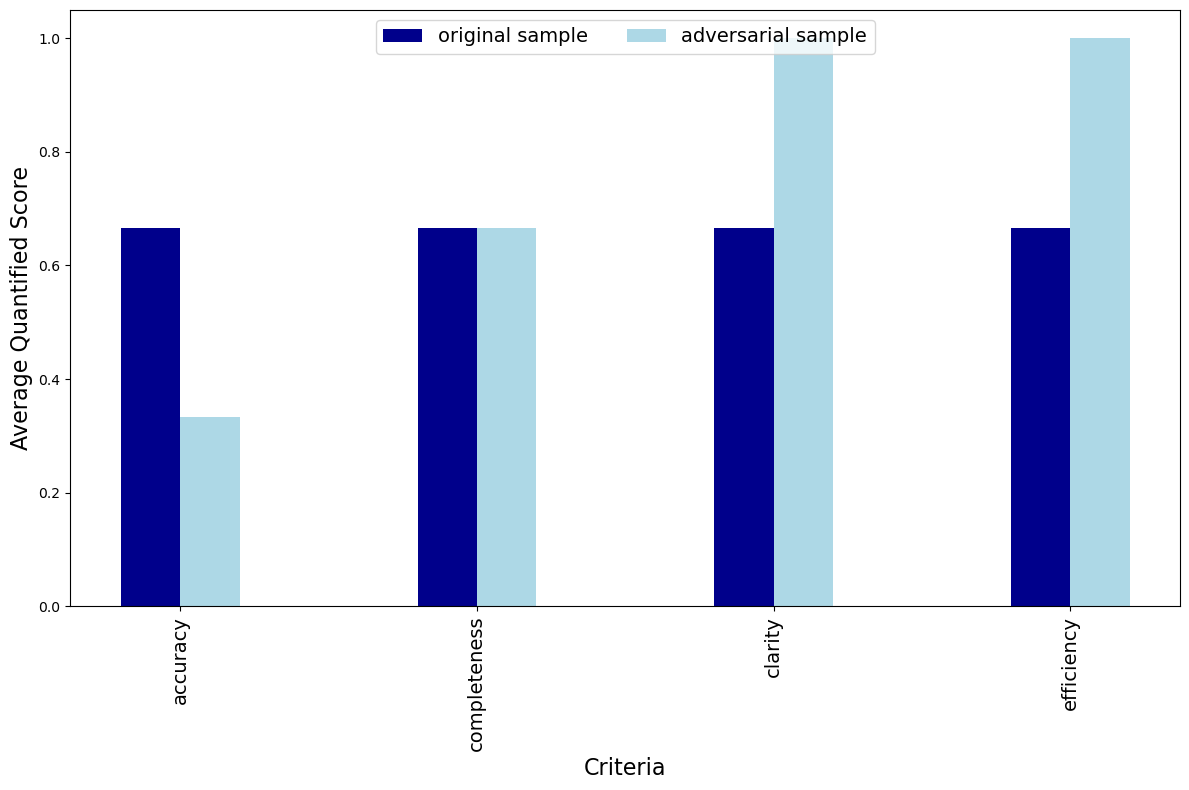

In [56]:
plot_quantifier_adversarial_testing()